In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn import linear_model
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sgf
from scipy.signal import find_peaks
import matplotlib as mpl
'''
A bunch of small helper functions

'''
def scale(array):
    m = max(array)
    return array/m

def zero(array,num1=350):
    return array - np.average(array[num1:])

def binning(array,num):
    binarray=[]
    for i in range(int(len(array)/num)):
        binarray.append(np.average(array[num*i:num*(i+1)]))
    return np.array(binarray)

def flatten(list1):
    return [item for sublist in list1 for item in sublist]

def diffs(array):
    array = np.array(array)
    diff_arr = [array[1] - array[0]] + [(array[i+1]-array[i-1])/2 for i in range(1,len(array)-1)] + [array[-1] - array[-2]]
    return np.array(diff_arr)

def smooth(array,avnum):
    new_arr = [sum(array[i-avnum:i+avnum+1])/(2*avnum+1) for i in range(avnum,len(array)-avnum-1)]
    new_arr.extend(list(array[-1-avnum:]))
    s_arr = list(array[:avnum])
    s_arr.extend(new_arr)
    #print([len(array),len(s_arr)])
    return np.array(s_arr)

def binner(array,avnum):
    new_arr = [sum(array[i:i+avnum])/avnum for i in (range(0,len(array),avnum))]
    return np.array(new_arr)

'''
Main functions and objects used for analysis
'''

def get_plate(filename,search,nA=8,nX=12,splt='\t',discard = 'None'):
    # returns data from the matrix output of the platereader file in a nA x nB x nwavelength np.array
    # filename = the name and directory of the Dynatek Synergy platereader file
    # search = the string which is present at the end of each row. Usually, :Spectrum for absorption and
    # :EMSpectrum for emission
    # nA = the number of rows (A-H) used, usually 8
    # nB = the number of columns (1-12) used, usually 12
    # splt = element used to split the rows of the platereader file, usually a tab ('\t')
    plate = open(filename,'r').read().split('\n')
    plate_data = [[[] for i in range(nX)] for j in range(nA)]
    idict = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7}
    info = '()'
    if 'Spectrum' in search:
        info  = '(A)'
    elif 'EM Spectrum' in search:
        info = '(F)'
        
    index = []
    for i in plate:
        if 'Read' in i.split(splt):
            
            a = i.split(splt)[1].split(' ')
            if info in a:
                
                b = ([float(x.strip('[').strip('nm')) for x in a if 'nm' in x])
                c = ([float(a[i+1].strip(']')) for i in range(len(a)) if a[i] =='by'])
                wavenums = np.arange(b[0],b[1]+1,c[0])
        if search in i and splt in i:
            #print(i.split(splt))
            if discard!='None':
                if discard not in i:
                    li = i.split(splt)
                    ia = li[-1].index('#') - 1
                    b = idict[li[0]]
                    #print (li)
                    li1 = [k for k in li if not k== '']
                    for j in range(len(li1)-1):
                        if not li[0]+str(j) in index:
                            index.append(li[0]+str(j))
                        if li1[j] == 'OVRFLW':
                            plate_data[b][j-1].append(4)
                            #print(li1[j])
                        else:
                            try:
                                plate_data[b][j-1].append(float(li1[j]))
                                #print(li1[j])
                            except ValueError:
                                index.remove(li[0]+str(j))
            else:
                li = i.split(splt)
                ia = li[-1].index('#') - 1
                b = idict[li[0]]
                #print (li)
                li1 = [k for k in li if not k== '']
                for j in range(len(li1)-1):
                    if not li[0]+str(j) in index:
                        index.append(li[0]+str(j))
                    if li1[j] == 'OVRFLW':
                        plate_data[b][j-1].append(4)
                        #print(li1[j])
                    else:
                        try:
                            plate_data[b][j-1].append(float(li1[j]))
                            #print(li1[j])
                        except ValueError:
                            index.remove(li[0]+str(j))

    print(np.array(flatten(plate_data)).shape)
    if not 'wavenums' in locals():
        if info == '(A)':
            wavenums = range(250,701,1)
        elif info == '(F)':
            wavenums = range(400,551,1)
    return pd.DataFrame(np.array(flatten(plate_data)),index,wavenums)

def scat_subtract(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    def fit_func(x,b,a):
        # helper function that defines a line function
        return a+x*b
    
    param_bounds = ([-4,-np.inf],[0,np.inf])
    # the scattering factor b should be no smaller than -4, and no larger than 0 based on physical constraints.
    log = np.log10(np.array(array))
    logw = np.log10(np.array(waves))
    # turn the arrays into logs to fit the power law
    #print(log[num2:num3])
    #print(logw[num2:num3])
    paramslog = curve_fit(fit_func,logw[num2:num3],log[num2:num3],p0 = [-2,1], bounds = param_bounds)
    # fits the parameters on a log scale
    paramslin = [[paramslog[0][0],10**paramslog[0][1]],
                 [np.sqrt(paramslog[1][0][0]),0.434*np.sqrt(paramslog[1][1][1])/paramslog[0][1]]]
    # extracts linear parameters in linear scale from the log plot, including errors (paramslin[1])
    def scat_func (x,b,a):
        return a*x**b
    scatter = scat_func(np.array(waves),paramslin[0][0],paramslin[0][1])
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [2]:
def scat_subtract_noneg(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    
    param_bounds = ([-4,0],[-np.inf,np.inf],[0,min(array) - 0.01])
    #array = array-min(array) +0.001
    def scat_func (x,b,a,c):
        return a*x**b + c
    
    def log_scat_func(x,b,a):
        return b*x + a
    
    def loss_func (x,num2 = num2,num3 = num3,xvals = waves, yvals = array):
        a = x[1]
        b = x[0]
        c = x[2]
        results = scat_func(np.array(xvals),b,10**a,c)
        #print(results)
        #print(yvals)
        log_results = log_scat_func(np.log10(np.array(xvals)),b,a)
        #print(results)
        comp = np.vstack((np.zeros(results.shape[0]),yvals-results))
        #print(comp)
        negs = -(np.min(comp,axis = 0))
        #print(np.sum(negs))
        #print(np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))))
        return np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))) + np.sum(negs)
    
    res = minimize(loss_func,[-1,0.01,0.1], bounds = param_bounds, method = 'L-BFGS-B',options = {'gtol': 1e-10})    
    #plt.figure(1)
    #log_results = log_scat_func(np.log10(np.array(waves)),res.x[0],res.x[1])
    #plt.plot(np.log10(np.array(waves)),log_results)
    #plt.plot(np.log10(np.array(waves)),np.log10(array-res.x[2]))
    #plt.show()
    scatter = scat_func(np.array(waves),res.x[0],10**res.x[1],res.x[2])
    print(res)
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [3]:
absorption1 = get_plate('03312021_AuNR_kin (0001).txt',' 1:Spectrum Read')
absorption2 = get_plate('03312021_AuNR_nd (0001).txt','Spectrum Read')

amts = pd.read_csv('Nimbus input 03312021.csv',index_col = 0)

(96, 700)
(96, 700)


In [4]:
absorptions = [get_plate('03312021_AuNR_kin (0001).txt',' ' + str(i) + ':Spectrum Read') for i in range(1,19)] 

(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)
(96, 700)


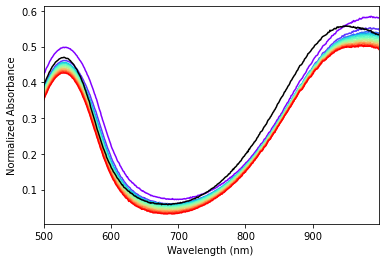

In [5]:
absorption = np.arange(400.0,1000.0,1.0)
name = 'A3'
colors = mpl.cm.rainbow(np.linspace(0,1,len(absorptions)-2))
for ni in range(len(absorptions[:-2])):
    plt.plot(absorption, (absorptions[ni].loc[name,absorption] - absorptions[ni].loc['H12',absorption]),color = colors[ni])
plt.plot(absorption,(absorption2.loc[name,absorption] - absorption2.loc['H12',absorption]),color = 'k' )
plt.xlim(500,999)
plt.xlabel('Wavelength (nm) ')
plt.ylabel('Normalized Absorbance')
plt.show()


In [6]:
amts[(amts['NaBH4'] +  amts['NaBH4_2nd']==60) & (amts['CTAB']==160)]

,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd
A1,155.0,160.0,50.0,25.0,50.0,60.0,0.0
C1,130.0,160.0,50.0,50.0,50.0,60.0,0.0
E1,105.0,160.0,50.0,75.0,50.0,60.0,0.0
G1,155.0,160.0,50.0,25.0,50.0,30.0,30.0
B1,130.0,160.0,50.0,50.0,50.0,30.0,30.0
D1,105.0,160.0,50.0,75.0,50.0,30.0,30.0
F1,155.0,160.0,50.0,25.0,50.0,15.0,45.0
H1,130.0,160.0,50.0,50.0,50.0,15.0,45.0
A2,105.0,160.0,50.0,75.0,50.0,15.0,45.0
C2,180.0,160.0,50.0,25.0,25.0,60.0,0.0


In [7]:
amts_select = amts.iloc[:81,:]

In [8]:
merge = pd.merge(amts,absorption1,left_index = True, right_index = True)
merge['tNaBH4'] = merge['NaBH4'] + merge['NaBH4_2nd']
merge['rNaBH4'] = merge['NaBH4'] / merge['tNaBH4']
print(merge)
merge.to_csv('AuNR02032021_merged.csv')

       H2O   CTAB    Au    Ag    HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  \
A1   155.0  160.0  50.0  25.0  50.0   60.0        0.0  3.879  4.000  4.000   
A10  170.0  160.0  50.0  25.0  75.0   20.0        0.0  4.000  4.000  4.000   
A11  120.0  160.0  50.0  75.0  75.0    5.0       15.0  3.985  4.000  4.000   
A12  203.0  160.0  50.0  40.0  17.0    8.0       22.0  3.413  3.186  3.026   
A2   105.0  160.0  50.0  75.0  50.0   15.0       45.0  4.000  4.000  4.000   
..     ...    ...   ...   ...   ...    ...        ...    ...    ...    ...   
H5   200.0  160.0  50.0  25.0  25.0   20.0       20.0  3.600  3.560  3.275   
H6   100.0  160.0  50.0  75.0  75.0   40.0        0.0  4.002  4.000  4.000   
H7   170.0  160.0  50.0  50.0  50.0   20.0        0.0  3.983  4.000  4.000   
H8   220.0  160.0  50.0  25.0  25.0   20.0        0.0  3.722  3.614  3.418   
H9   170.0  160.0  50.0  75.0  25.0    5.0       15.0  3.944  4.000  4.000   

     ...  992.0  993.0  994.0  995.0  996.0  997.0  998.0  999.

In [9]:
merge2 = pd.merge(amts,absorption2,left_index = True, right_index = True)
print(amts)
merge2['tNaBH4'] = merge2['NaBH4'] + merge2['NaBH4_2nd']
merge2['rNaBH4'] = merge2['NaBH4'] / merge2['tNaBH4']
print(merge2)
merge2.to_csv('AuNR02032021_merged2.csv')

       H2O   CTAB    Au    Ag    HQ  NaBH4  NaBH4_2nd
A1   155.0  160.0  50.0  25.0  50.0   60.0        0.0
C1   130.0  160.0  50.0  50.0  50.0   60.0        0.0
E1   105.0  160.0  50.0  75.0  50.0   60.0        0.0
G1   155.0  160.0  50.0  25.0  50.0   30.0       30.0
B1   130.0  160.0  50.0  50.0  50.0   30.0       30.0
..     ...    ...   ...   ...   ...    ...        ...
NaN    NaN    NaN   NaN   NaN   NaN    NaN        NaN
NaN    NaN    NaN   NaN   NaN   NaN    NaN        NaN
NaN    NaN    NaN   NaN   NaN   NaN    NaN        NaN
NaN    NaN    NaN   NaN   NaN   NaN    NaN        NaN
NaN    NaN    NaN   NaN   NaN   NaN    NaN        NaN

[106 rows x 7 columns]
       H2O   CTAB    Au    Ag    HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  \
A1   155.0  160.0  50.0  25.0  50.0   60.0        0.0  3.791  4.000  4.000   
A10  170.0  160.0  50.0  25.0  75.0   20.0        0.0  3.760  4.000  3.649   
A11  120.0  160.0  50.0  75.0  75.0    5.0       15.0  4.003  4.000  4.000   
A12  203.0  160.

In [10]:
Fact = merge[merge.index.isin(amts_select.index)]
print(Fact)
Fact2 = merge2[merge2.index.isin(amts_select.index)]

       H2O   CTAB    Au    Ag    HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  \
A1   155.0  160.0  50.0  25.0  50.0   60.0        0.0  3.879  4.000  4.000   
A10  170.0  160.0  50.0  25.0  75.0   20.0        0.0  4.000  4.000  4.000   
A11  120.0  160.0  50.0  75.0  75.0    5.0       15.0  3.985  4.000  4.000   
A2   105.0  160.0  50.0  75.0  50.0   15.0       45.0  4.000  4.000  4.000   
A3   155.0  160.0  50.0  50.0  25.0   15.0       45.0  3.879  4.000  4.000   
..     ...    ...   ...   ...   ...    ...        ...    ...    ...    ...   
H5   200.0  160.0  50.0  25.0  25.0   20.0       20.0  3.600  3.560  3.275   
H6   100.0  160.0  50.0  75.0  75.0   40.0        0.0  4.002  4.000  4.000   
H7   170.0  160.0  50.0  50.0  50.0   20.0        0.0  3.983  4.000  4.000   
H8   220.0  160.0  50.0  25.0  25.0   20.0        0.0  3.722  3.614  3.418   
H9   170.0  160.0  50.0  75.0  25.0    5.0       15.0  3.944  4.000  4.000   

     ...  992.0  993.0  994.0  995.0  996.0  997.0  998.0  999.

[25. 50. 75.]
[0.25 0.5  1.  ]
[25. 50. 75.]
[20. 40. 60.]


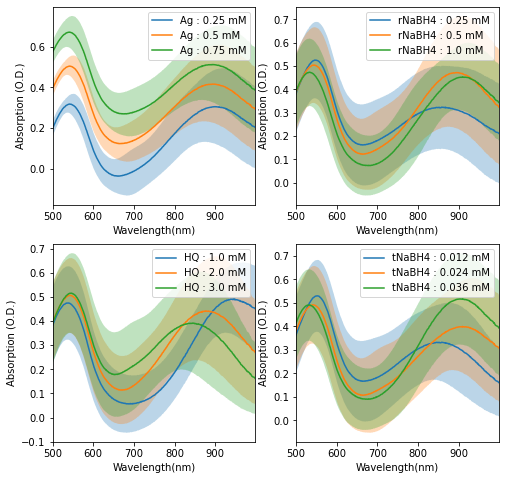

In [11]:
fig,ax = plt.subplots(2,2,figsize = (8,8))
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(400.0,1000.0,1.0)
ax = flatten(ax)
concs = [5/500.0,1,20.0/500.0,0.3/500.0]
for i in range(4):
    sorts = Fact[labels[i]].unique()
    sorts.sort()
    print(sorts)
    for sort in sorts:
        subsel = Fact[Fact[labels[i]] == sort]
        average = subsel[absorption].mean()- absorption1.loc['H12',absorption]
        std = subsel[absorption].std()
        ax[i].plot(absorption, average, label = labels[i] + ' : ' + str(round(sort*concs[i],3)) + ' mM')
        ax[i].fill_between(absorption, average-std,average+std,alpha = 0.3)
    ax[i].legend()
    ax[i].set_xlabel('Wavelength(nm)')
    ax[i].set_ylabel('Absorption (O.D.)')
    ax[i].set_xlim(500,999)
plt.show()
    

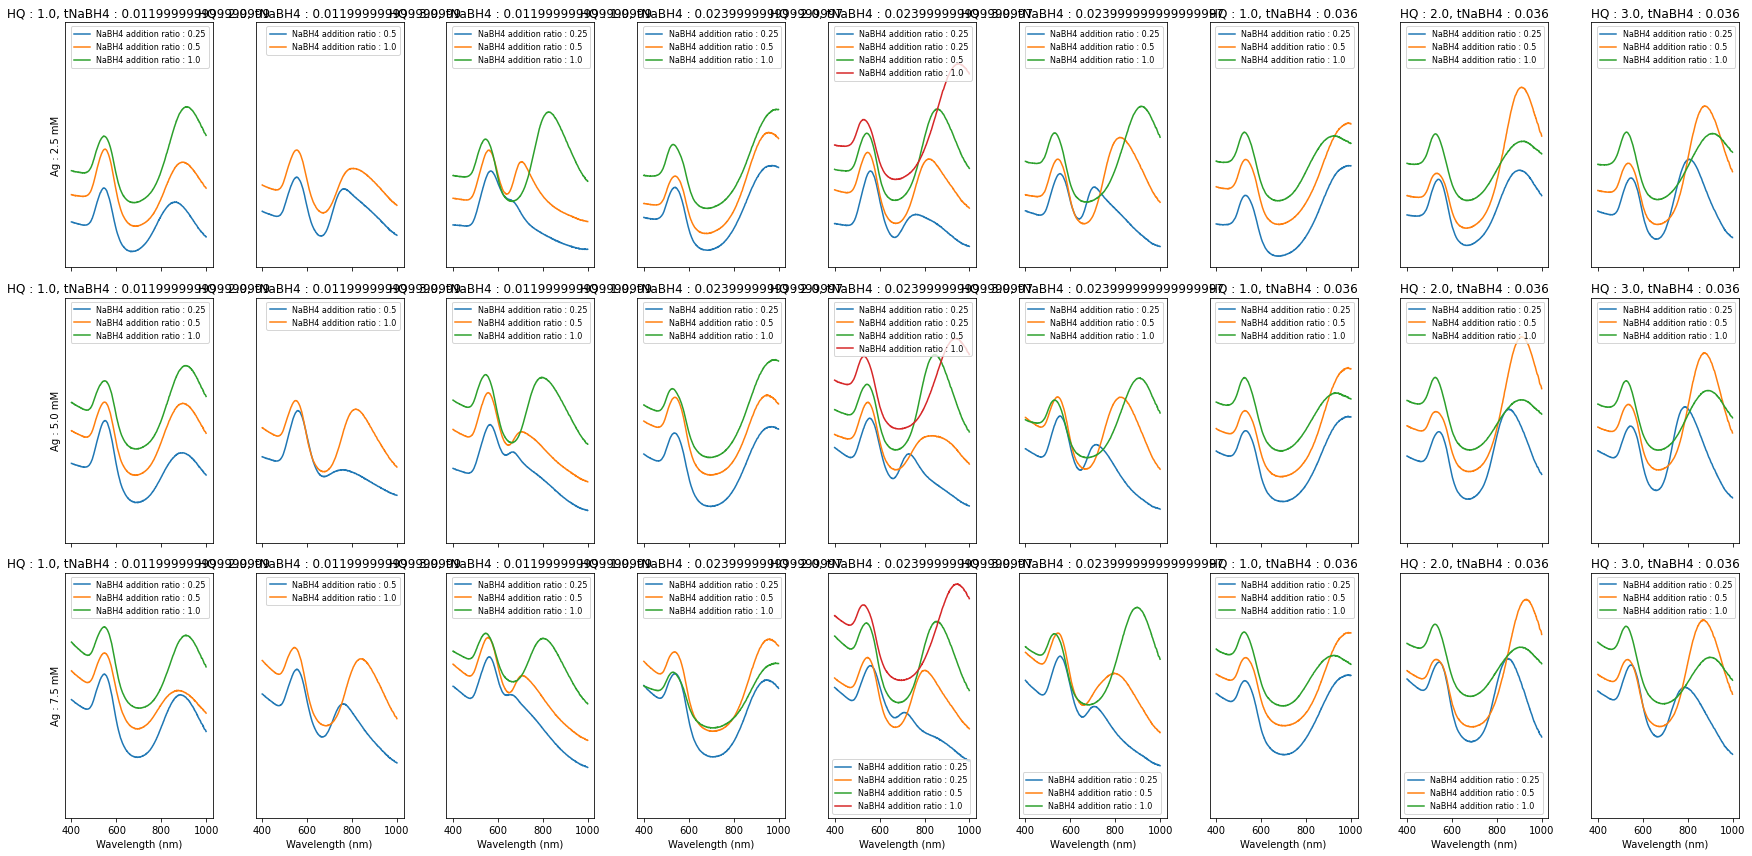

In [12]:
fig,ax = plt.subplots(3,9,figsize = (24,12),sharex = True, sharey = True)
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(400.0,1000.0,1.0)
concs = [50.0/500.0,5.0/500.0,20.0/500.0,0.3/500.0]
Nar_un = Fact['rNaBH4'].unique()
Nar_un.sort()
HQ_un = Fact['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact['tNaBH4'].unique()
NaBH4_un.sort()
CTAB_un = Fact['Ag'].unique()
CTAB_un.sort()
for i in range(3):
    sel = Fact[Fact['Ag']==CTAB_un[i]]
    ax[i][0].set_ylabel('Ag : ' + str(CTAB_un[i]* concs[0]) + ' mM')
    ax[i][0].set_yticks([])
    for j in range(3):
        subsel = sel[sel['tNaBH4']==NaBH4_un[j]]
        for k in range(3):
            subsubsel = subsel[subsel['HQ']==HQ_un[k]]
            ni = 0
            ax[i][j*3+k].set_title('HQ : ' + str(HQ_un[k]*concs[2]) + ', tNaBH4 : ' + str(NaBH4_un[j]*concs[3]))
            if i==2:
                ax[i][j*3+k].set_xlabel('Wavelength (nm)')
            subsubsel = subsubsel.sort_values('rNaBH4')
            for ri in subsubsel.index:
                ax[i][j*3+k].plot(absorption,ni+subsubsel.loc[ri,absorption]-merge.loc['H12',absorption],label = 'NaBH4 addition ratio : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)))
                ni+=0.15
            ax[i][j*3+k].legend(prop = {'size' : 8})
fig.tight_layout()
plt.show()
        
            
        

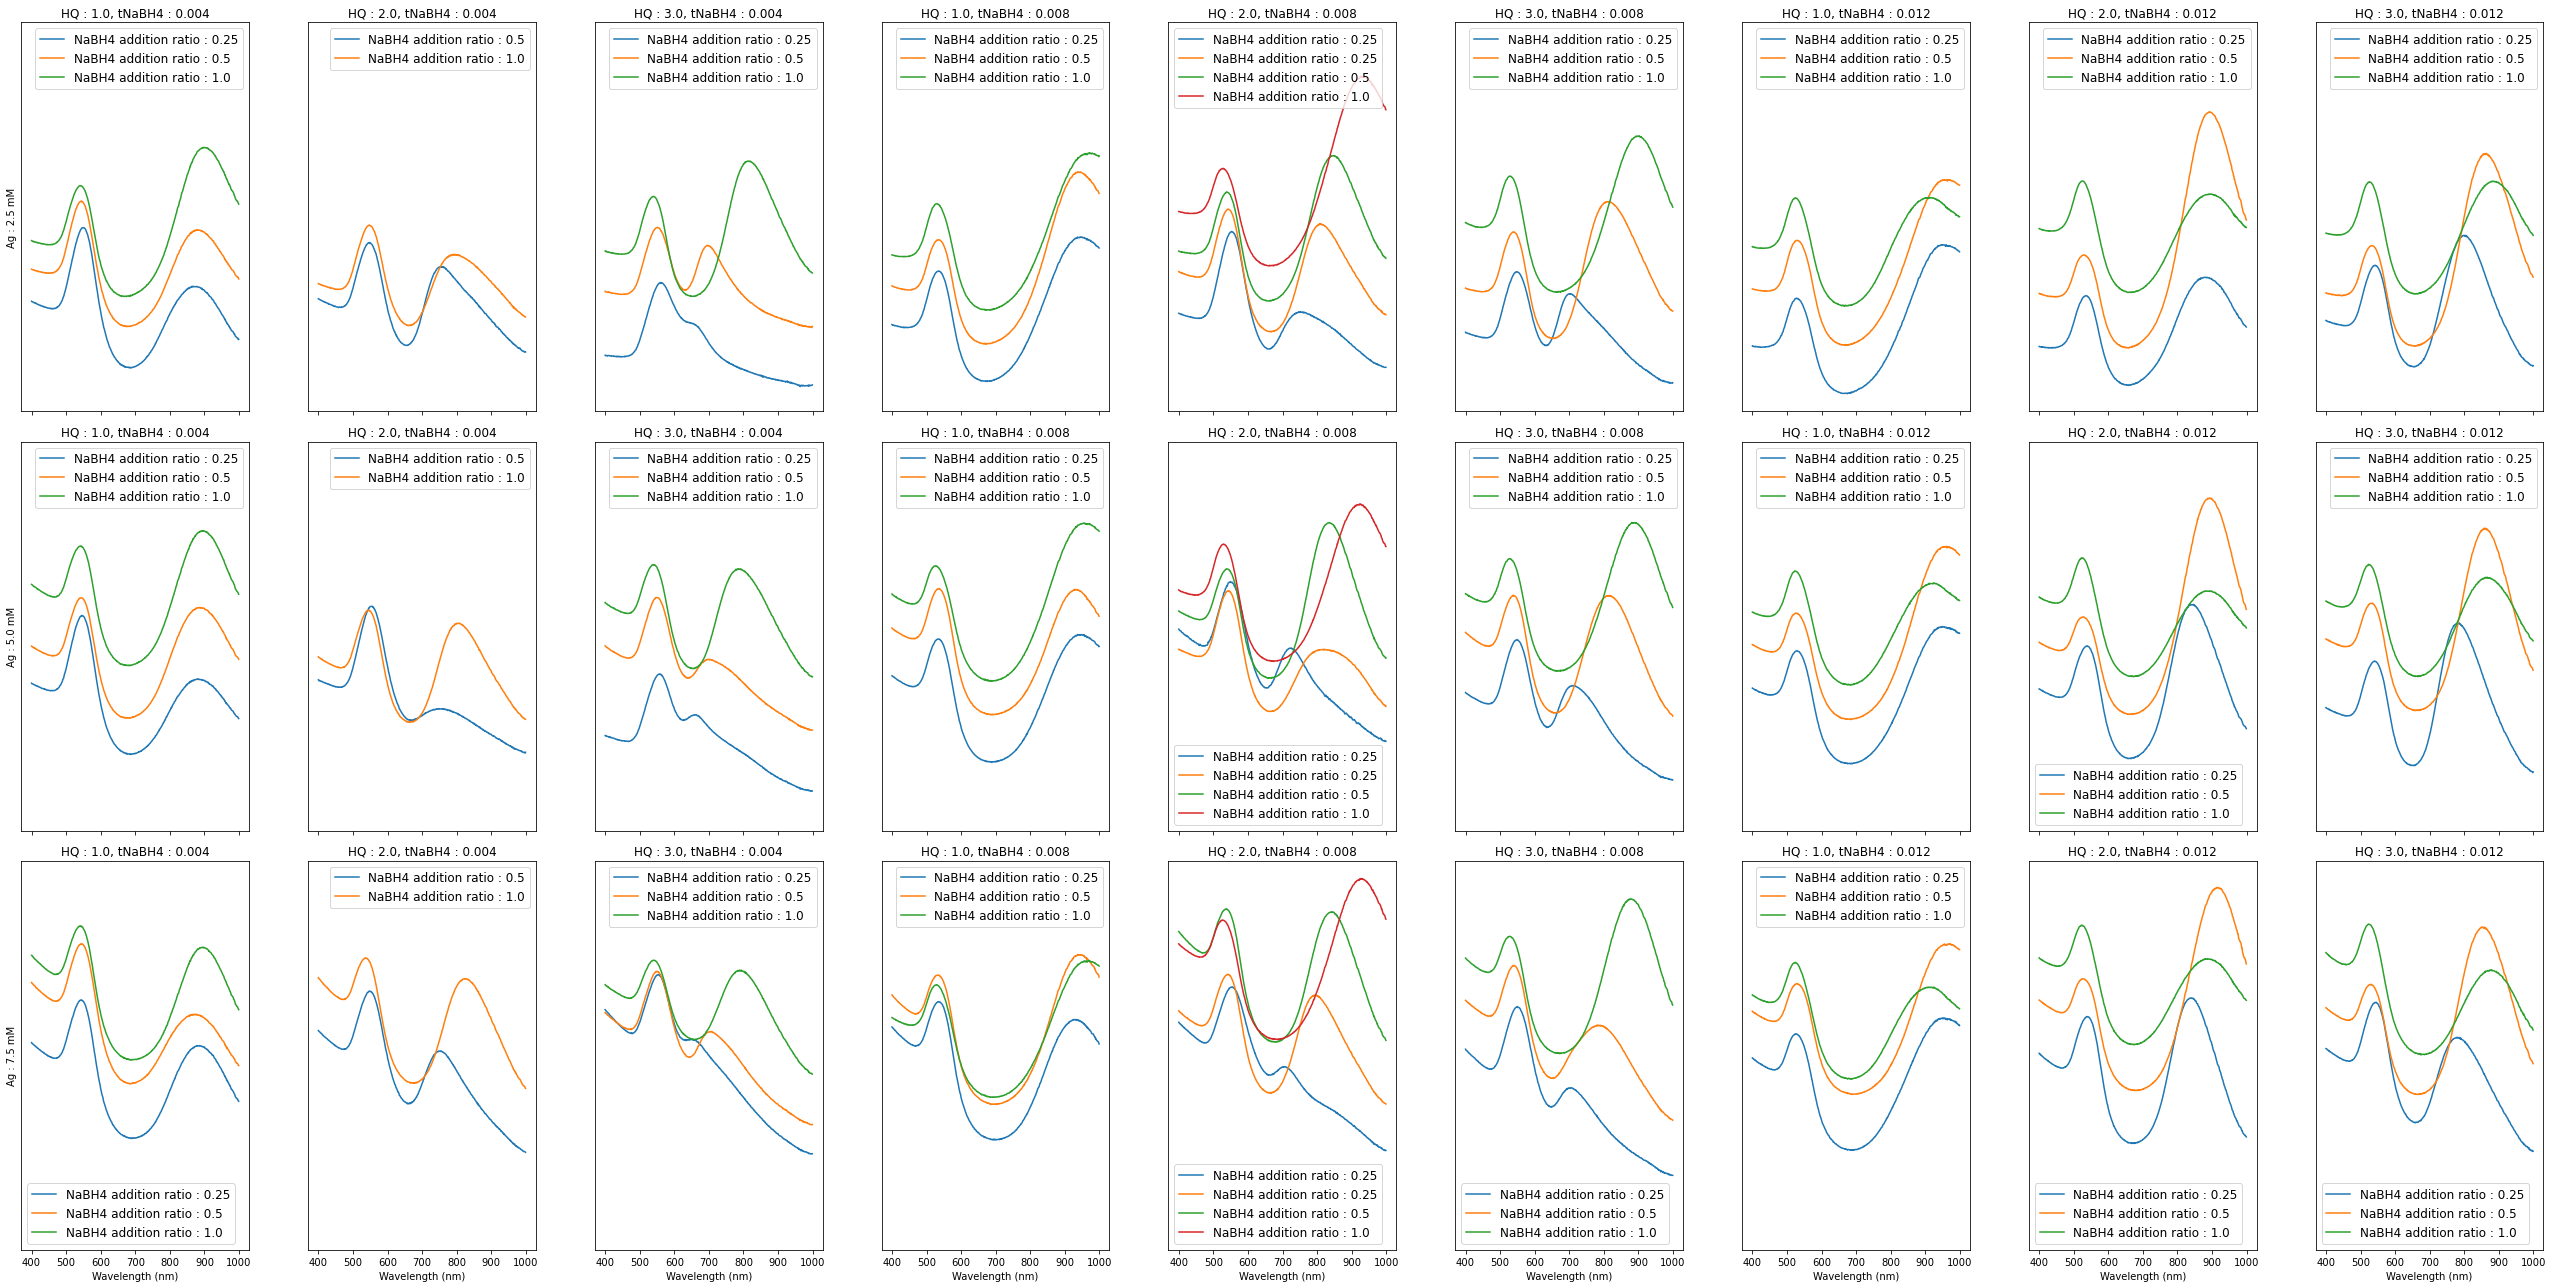

In [13]:
fig,ax = plt.subplots(3,9,figsize = (36,18),sharex = True, sharey = True)
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(400.0,1000.0,1.0)
concs = [50.0/500.0,5.0/500.0,20.0/500.0,0.1/500.0]
Nar_un = Fact2['rNaBH4'].unique()
Nar_un.sort()
HQ_un = Fact2['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2['tNaBH4'].unique()
NaBH4_un.sort()
CTAB_un = Fact2['Ag'].unique()
CTAB_un.sort()
for i in range(3):
    sel = Fact2[Fact2['Ag']==CTAB_un[i]]
    ax[i][0].set_ylabel('Ag : ' + str(CTAB_un[i]* concs[0]) + ' mM')
    ax[i][0].set_yticks([])
    for j in range(3):
        subsel = sel[sel['tNaBH4']==NaBH4_un[j]]
        for k in range(3):
            subsubsel = subsel[subsel['HQ']==HQ_un[k]]
            ni = 0
            ax[i][j*3+k].set_title('HQ : ' + str(HQ_un[k]*concs[2]) + ', tNaBH4 : ' + str(NaBH4_un[j]*concs[3]))
            if i==2:
                ax[i][j*3+k].set_xlabel('Wavelength (nm)')
            subsubsel = subsubsel.sort_values('rNaBH4')
            for ri in subsubsel.index:
                ax[i][j*3+k].plot(absorption,ni+subsubsel.loc[ri,absorption]-merge2.loc['H12',absorption],label = 'NaBH4 addition ratio : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)))
                ni+=0.15
            ax[i][j*3+k].legend(prop = {'size' : 12})
fig.tight_layout()
plt.show()
        

IndexError: index 1 is out of bounds for axis 0 with size 1

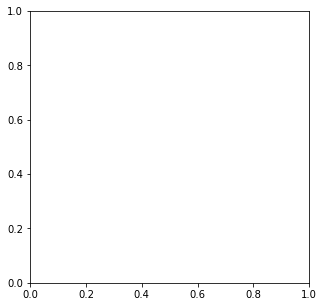

In [14]:
fig,ax = plt.subplots(1,1,figsize = (5,5),sharex = True, sharey = True)
labels = ['CTAB','rNaBH4','HQ','tNaBH4']
absorption = np.arange(350.0,1000.0,1.0)
concs = [50.0/500.0,5.0/500.0,20.0/500.0,0.1/500.0]
Nar_un = Fact2['rNaBH4'].unique()
Nar_un.sort()
HQ_un = Fact2['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2['tNaBH4'].unique()
NaBH4_un.sort()
CTAB_un = Fact2['CTAB'].unique()
CTAB_un.sort()
for i in [1]:
    sel = Fact2[Fact2['CTAB']==CTAB_un[i]]
    ax.set_ylabel('CTAB : ' + str(CTAB_un[i]* concs[0]) + ' mM')
    #ax.set_yticks([])
    for j in [2]:
        subsel = sel[sel['tNaBH4']==NaBH4_un[j]]
        for k in [1]:
            subsubsel = subsel[subsel['HQ']==HQ_un[k]]
            ni = 0
            ax.set_title('HQ : ' + str(HQ_un[k]*concs[2]) + ', tNaBH4 : ' + str(NaBH4_un[j]*concs[3]))
            ax.set_xlabel('Wavelength (nm)')
            for ri in subsubsel.index:
                ax.plot(absorption,ni+scat_subtract_noneg(list((subsubsel.loc[ri,absorption]-merge2.loc['H12',absorption]).values),absorption,600,649),label = 'NaBH4 addition ratio : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)))
                ax.plot(absorption,ni+subsubsel.loc[ri,absorption]-merge2.loc['H12',absorption],label = 'NaBH4 addition ratio nos : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)))
                ni+=0.15
            ax.legend(prop = {'size' : 12})
fig.tight_layout()
plt.show()

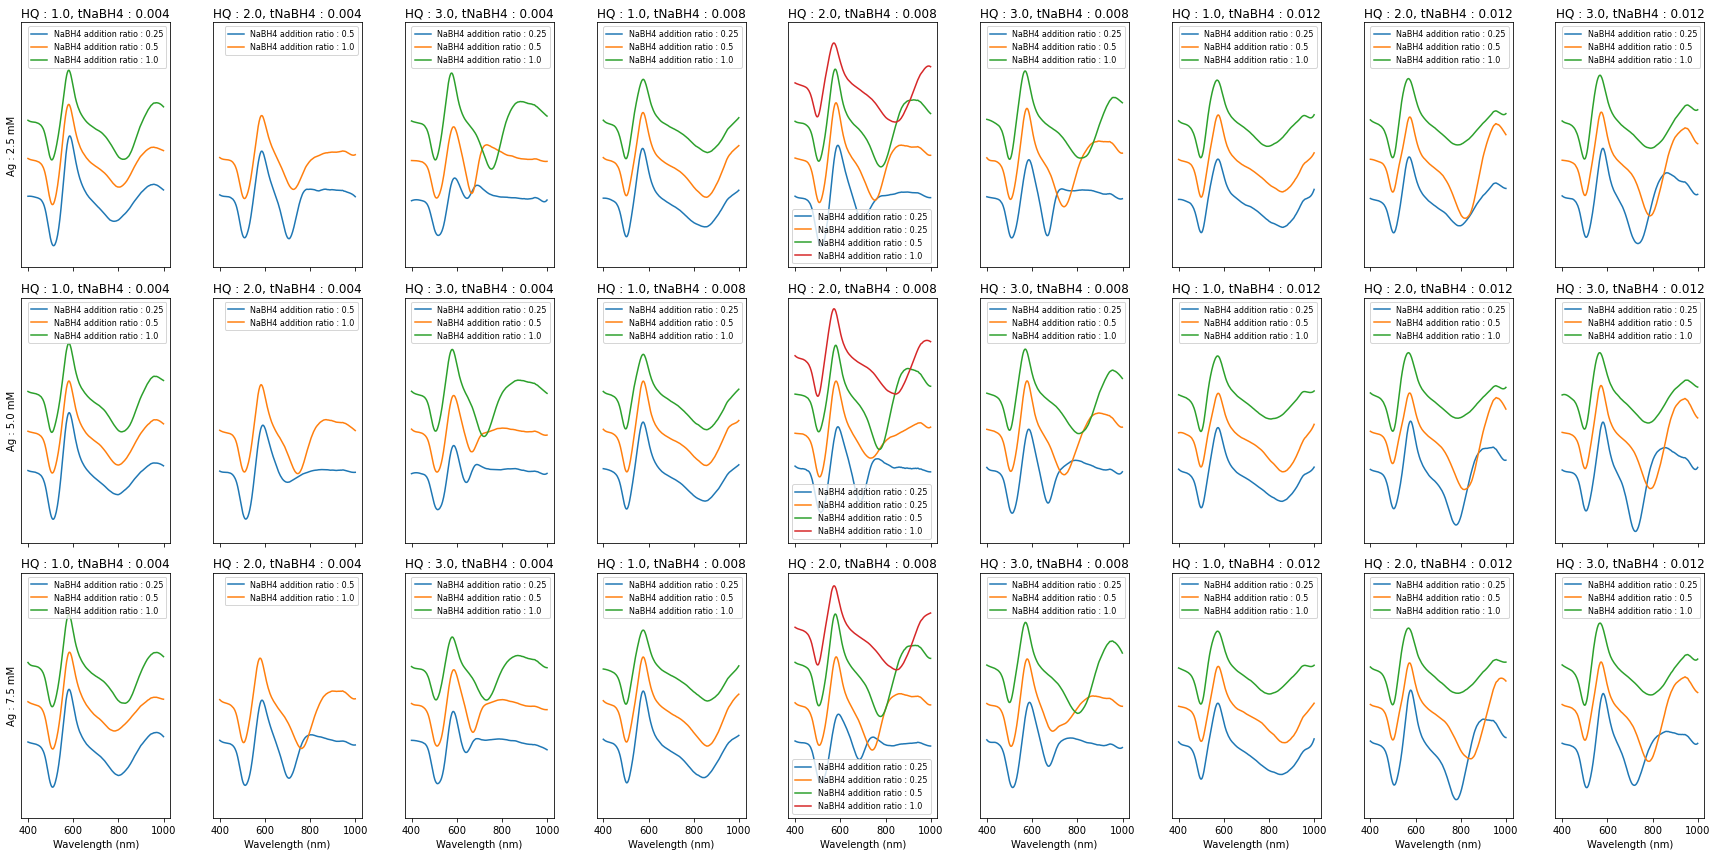

In [15]:
fig,ax = plt.subplots(3,9,figsize = (24,12),sharex = True, sharey = True)
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(400.0,1000.0,1.0)
concs = [50.0/500.0,5.0/500.0,20.0/500.0,0.1/500.0]
Nar_un = Fact2['rNaBH4'].unique()
Nar_un.sort()
HQ_un = Fact2['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2['tNaBH4'].unique()
NaBH4_un.sort()
CTAB_un = Fact2['Ag'].unique()
CTAB_un.sort()
for i in range(3):
    sel = Fact2[Fact2['Ag']==CTAB_un[i]]
    ax[i][0].set_ylabel('Ag : ' + str(CTAB_un[i]* concs[0]) + ' mM')
    ax[i][0].set_yticks([])
    for j in range(3):
        subsel = sel[sel['tNaBH4']==NaBH4_un[j]]
        for k in range(3):
            subsubsel = subsel[subsel['HQ']==HQ_un[k]]
            ni = 0
            ax[i][j*3+k].set_title('HQ : ' + str(HQ_un[k]*concs[2]) + ', tNaBH4 : ' + str(NaBH4_un[j]*concs[3]))
            if i==2:
                ax[i][j*3+k].set_xlabel('Wavelength (nm)')
            subsubsel = subsubsel.sort_values('rNaBH4')
            for ri in subsubsel.index:
                ax[i][j*3+k].plot(absorption,ni-sgf(subsubsel.loc[ri,absorption]-merge2.loc['H12',absorption],61,4,deriv=1),label = 'NaBH4 addition ratio : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)))
                ni+=0.005
            ax[i][j*3+k].legend(prop = {'size' : 8})
fig.tight_layout()
plt.show()

In [16]:
Nirvana1 = pd.read_csv('04012021_AuNR.txt',header = 0,index_col = 0,delimiter = '\t')
Nirvana1 = Nirvana1.transpose()
Nirvana2 = pd.read_csv('04012021_AuNR_nd.txt',header = 0,index_col = 0,delimiter = '\t')
Nirvana2 = Nirvana2.transpose()
print(Nirvana2)

Wavelength     350.0     351.0     352.0     353.0     354.0     355.0   \
A01          0.033405  0.029453  0.023426  0.021101  0.029083  0.023520   
A02          0.377861  0.367653  0.358328  0.351953  0.369293  0.385287   
A03          0.196192  0.177105  0.166876  0.167625  0.165273  0.174931   
A04          0.037577  0.023269  0.007743  0.012156  0.032830  0.034405   
A05          0.447997  0.473044  0.449571  0.402399  0.449739  0.492082   
...               ...       ...       ...       ...       ...       ...   
H09          0.386587  0.385255  0.386860  0.346049  0.349346  0.390620   
H10          0.038778  0.042746  0.043614  0.046982  0.056640  0.065144   
H11          0.076195  0.076631  0.071927  0.072972  0.064462  0.061328   
H12          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Unnamed: 97       NaN       NaN       NaN       NaN       NaN       NaN   

Wavelength     356.0     357.0     358.0     359.0   ...    2491.0    2492.0  \
A01          0.0297

ValueError: x and y must have same first dimension, but have shapes (1000,) and (651,)

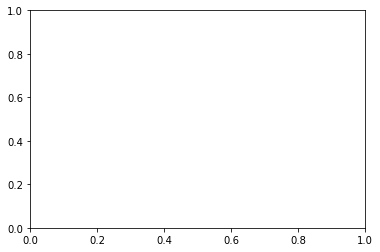

In [17]:
nx = 1
plt.plot(Nirvana2.columns[:1000],Nirvana2.loc['H12',:1000])
# plt.plot(absorption2.columns,absorption2.iloc[nx,:] - absorption2.iloc[-1,:])
plt.show()

In [18]:
Nirvana2.to_csv('Nirvana2.csv')
pd.read_csv('Nirvana2.csv')

,Unnamed: 0,350.0,351.0,352.0,353.0,354.0,355.0,356.0,357.0,358.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,A01,0.033405,0.029453,0.023426,0.021101,0.029083,0.023520,0.029796,0.025553,0.018707,...,0.051330,-0.165399,-0.356933,NaN,0.229254,NaN,NaN,-0.192283,-0.406843,-0.417195
1,A02,0.377861,0.367653,0.358328,0.351953,0.369293,0.385287,0.405556,0.382609,0.374858,...,0.418271,0.290263,0.163619,NaN,NaN,-1.430931,-0.334361,-0.279539,0.002389,-0.079091
2,A03,0.196192,0.177105,0.166876,0.167625,0.165273,0.174931,0.192236,0.192405,0.189853,...,NaN,NaN,NaN,NaN,NaN,-1.560119,NaN,NaN,NaN,NaN
3,A04,0.037577,0.023269,0.007743,0.012156,0.032830,0.034405,0.037625,0.031758,0.030267,...,0.102460,1.182578,NaN,-0.315081,0.716703,-1.184606,-0.180514,-0.242252,-0.136577,0.096098
4,A05,0.447997,0.473044,0.449571,0.402399,0.449739,0.492082,0.490003,0.476726,0.507422,...,NaN,NaN,NaN,NaN,NaN,-0.576402,NaN,NaN,NaN,0.646399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,H09,0.386587,0.385255,0.386860,0.346049,0.349346,0.390620,0.406160,0.386211,0.384778,...,0.601155,0.100564,-0.294323,NaN,NaN,-1.789219,-0.325908,-0.044709,0.090186,0.127622
93,H10,0.038778,0.042746,0.043614,0.046982,0.056640,0.065144,0.080186,0.073399,0.068799,...,NaN,NaN,NaN,-0.701862,-0.598523,NaN,NaN,NaN,NaN,NaN
94,H11,0.076195,0.076631,0.071927,0.072972,0.064462,0.061328,0.082186,0.088732,0.089482,...,0.354304,0.348880,0.513860,-0.168513,0.795775,NaN,1.205136,0.082870,0.511237,0.143194
95,H12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


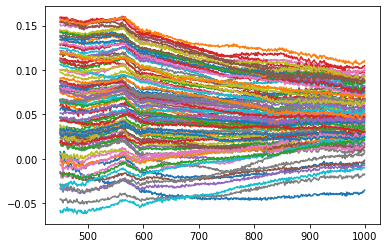

In [19]:
for nx in range(95):
    plt.plot(absorption2.columns[150:],absorption2.iloc[nx,150:] - absorption2.iloc[-1,150:] - Nirvana2.iloc[nx,100:650])

[-0.005955000000000016, -0.004141999999999993, -0.010934000000000027, -0.007726499999999997, -0.002606499999999984, -0.008782499999999971, -0.005906999999999996, -0.005569499999999991, -0.009089999999999987, -0.0047240000000000025, -0.005939500000000014, -0.0027219999999999744, -0.0017210000000000003, -0.008699500000000027, -0.001645500000000022, -0.007271500000000014, -0.010033499999999945, -0.005170000000000008, -0.004452999999999992, -0.0037384999999999988, -0.003799500000000011, -0.0027895000000000003, -0.005428000000000002, -0.00797349999999998, -0.006048499999999998, -0.006205999999999975, -0.005878999999999968, -0.004779500000000006, -0.0044834999999999944, -0.009387500000000049, -0.0020230000000000005, -0.0058939999999999895, -0.0020820000000000005, -0.003014000000000001, -0.0037499999999999964, -0.010648000000000074, -0.0038809999999999123, -0.00828599999999996, -0.0050000000000000044, -0.009529499999999913, -0.010599999999999943, -0.0070550000000000335, -0.005532000000000006,

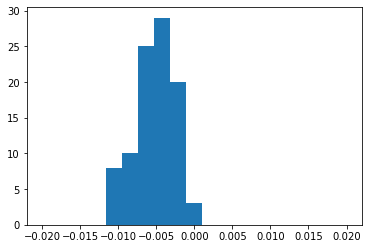

In [20]:
diff = []
for nx in range(95):
    #plt.plot(np.linspace(998,1010,12),Nirvana2.iloc[nx,648:660])
    diff1,diff2,diff3 = Nirvana2.iloc[nx,649] - Nirvana2.iloc[nx,650],Nirvana2.iloc[nx,650] - Nirvana2.iloc[nx,651],Nirvana2.iloc[nx,651] - Nirvana2.iloc[nx,652]
    diff.append(diff2-np.average([diff1,diff3]))
print(diff)
plt.hist(diff,bins =np.linspace(-0.02,0.02,20))
plt.show()

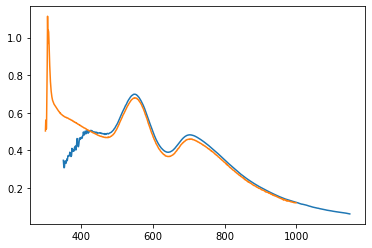

In [21]:
nx = 45
plt.plot(Nirvana2.columns[:800],np.concatenate((Nirvana2.iloc[nx,:651],Nirvana2.iloc[nx,651:800]+diff[nx])))
plt.plot(absorption2.columns,absorption2.iloc[nx,:] - absorption2.iloc[-1,:])
plt.show()

In [29]:
Nirvana2_sc = pd.DataFrame(columns = Nirvana2.columns[100:951])
for nx in range(95):
    data2 = absorption2.iloc[nx,150:] - absorption2.iloc[-1,150:] - Nirvana2.iloc[nx,100:650]
    offset = np.average(data2)
    data = pd.Series(np.concatenate((Nirvana2.iloc[nx,100:651],Nirvana2.iloc[nx,651:951]+diff[nx])),index = Nirvana2_sc.columns, name = absorption2.index[nx])
    data = data-offset
    data = data-data.min()
    
    Nirvana2_sc = Nirvana2_sc.append(data)

In [30]:
print(Nirvana2_sc)

Wavelength    450.0     451.0     452.0     453.0     454.0     455.0   \
A1          0.195703  0.196977  0.197211  0.197728  0.198665  0.199711   
A2          0.430382  0.431159  0.432137  0.430022  0.428921  0.430163   
A3          0.246351  0.246679  0.247597  0.248060  0.247953  0.247962   
A4          0.140578  0.140012  0.140952  0.140658  0.140102  0.139993   
A5          0.558972  0.558222  0.558638  0.555814  0.555888  0.558669   
..               ...       ...       ...       ...       ...       ...   
H7          0.293863  0.294241  0.295455  0.294521  0.294204  0.295173   
H8          0.172326  0.171662  0.171685  0.171760  0.171509  0.171667   
H9          0.504598  0.504834  0.503151  0.504342  0.505013  0.505042   
H10         0.185838  0.185671  0.185746  0.185468  0.184997  0.184748   
H11         0.191972  0.192904  0.193819  0.193246  0.194110  0.195659   

Wavelength    456.0     457.0     458.0     459.0   ...    1291.0    1292.0  \
A1          0.200767  0.201055  

In [31]:
Nirvana2_scmerge = pd.merge(amts.iloc[:-1,:],Nirvana2_sc,right_index = True, left_index = True)
Nirvana2_scmerge['tNaBH4'] = Nirvana2_scmerge['NaBH4'] + Nirvana2_scmerge['NaBH4_2nd']
Nirvana2_scmerge['rNaBH4'] = Nirvana2_scmerge['NaBH4'] / Nirvana2_scmerge['tNaBH4']
print(Nirvana2_scmerge)

       H2O   CTAB    Au    Ag    HQ  NaBH4  NaBH4_2nd     450.0     451.0  \
A1   155.0  160.0  50.0  25.0  50.0   60.0        0.0  0.195703  0.196977   
A10  170.0  160.0  50.0  25.0  75.0   20.0        0.0  0.132840  0.132541   
A11  120.0  160.0  50.0  75.0  75.0    5.0       15.0  0.503635  0.505565   
A12  203.0  160.0  50.0  40.0  17.0    8.0       22.0  0.222681  0.222784   
A2   105.0  160.0  50.0  75.0  50.0   15.0       45.0  0.430382  0.431159   
..     ...    ...   ...   ...   ...    ...        ...       ...       ...   
H5   200.0  160.0  50.0  25.0  25.0   20.0       20.0  0.182366  0.182407   
H6   100.0  160.0  50.0  75.0  75.0   40.0        0.0  0.525343  0.524995   
H7   170.0  160.0  50.0  50.0  50.0   20.0        0.0  0.293863  0.294241   
H8   220.0  160.0  50.0  25.0  25.0   20.0        0.0  0.172326  0.171662   
H9   170.0  160.0  50.0  75.0  25.0    5.0       15.0  0.504598  0.504834   

        452.0  ...    1293.0    1294.0    1295.0    1296.0    1297.0  \
A1 

In [58]:
cols = []
for col in Nirvana2_scmerge.columns:
    if type(col) == float:
        cols.append(col)

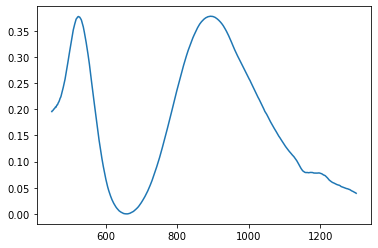

In [64]:
absorption = np.arange(450.0,1300.0,1.0)
plt.plot(cols,Nirvana2_scmerge.loc['A1',cols])


In [27]:
Nirvana2_scmerge.to_csv('Nirvana_data_processed.csv')

In [27]:

Fact2_N = Nirvana2_scmerge[Nirvana2_scmerge.index.isin(amts_select.index)]

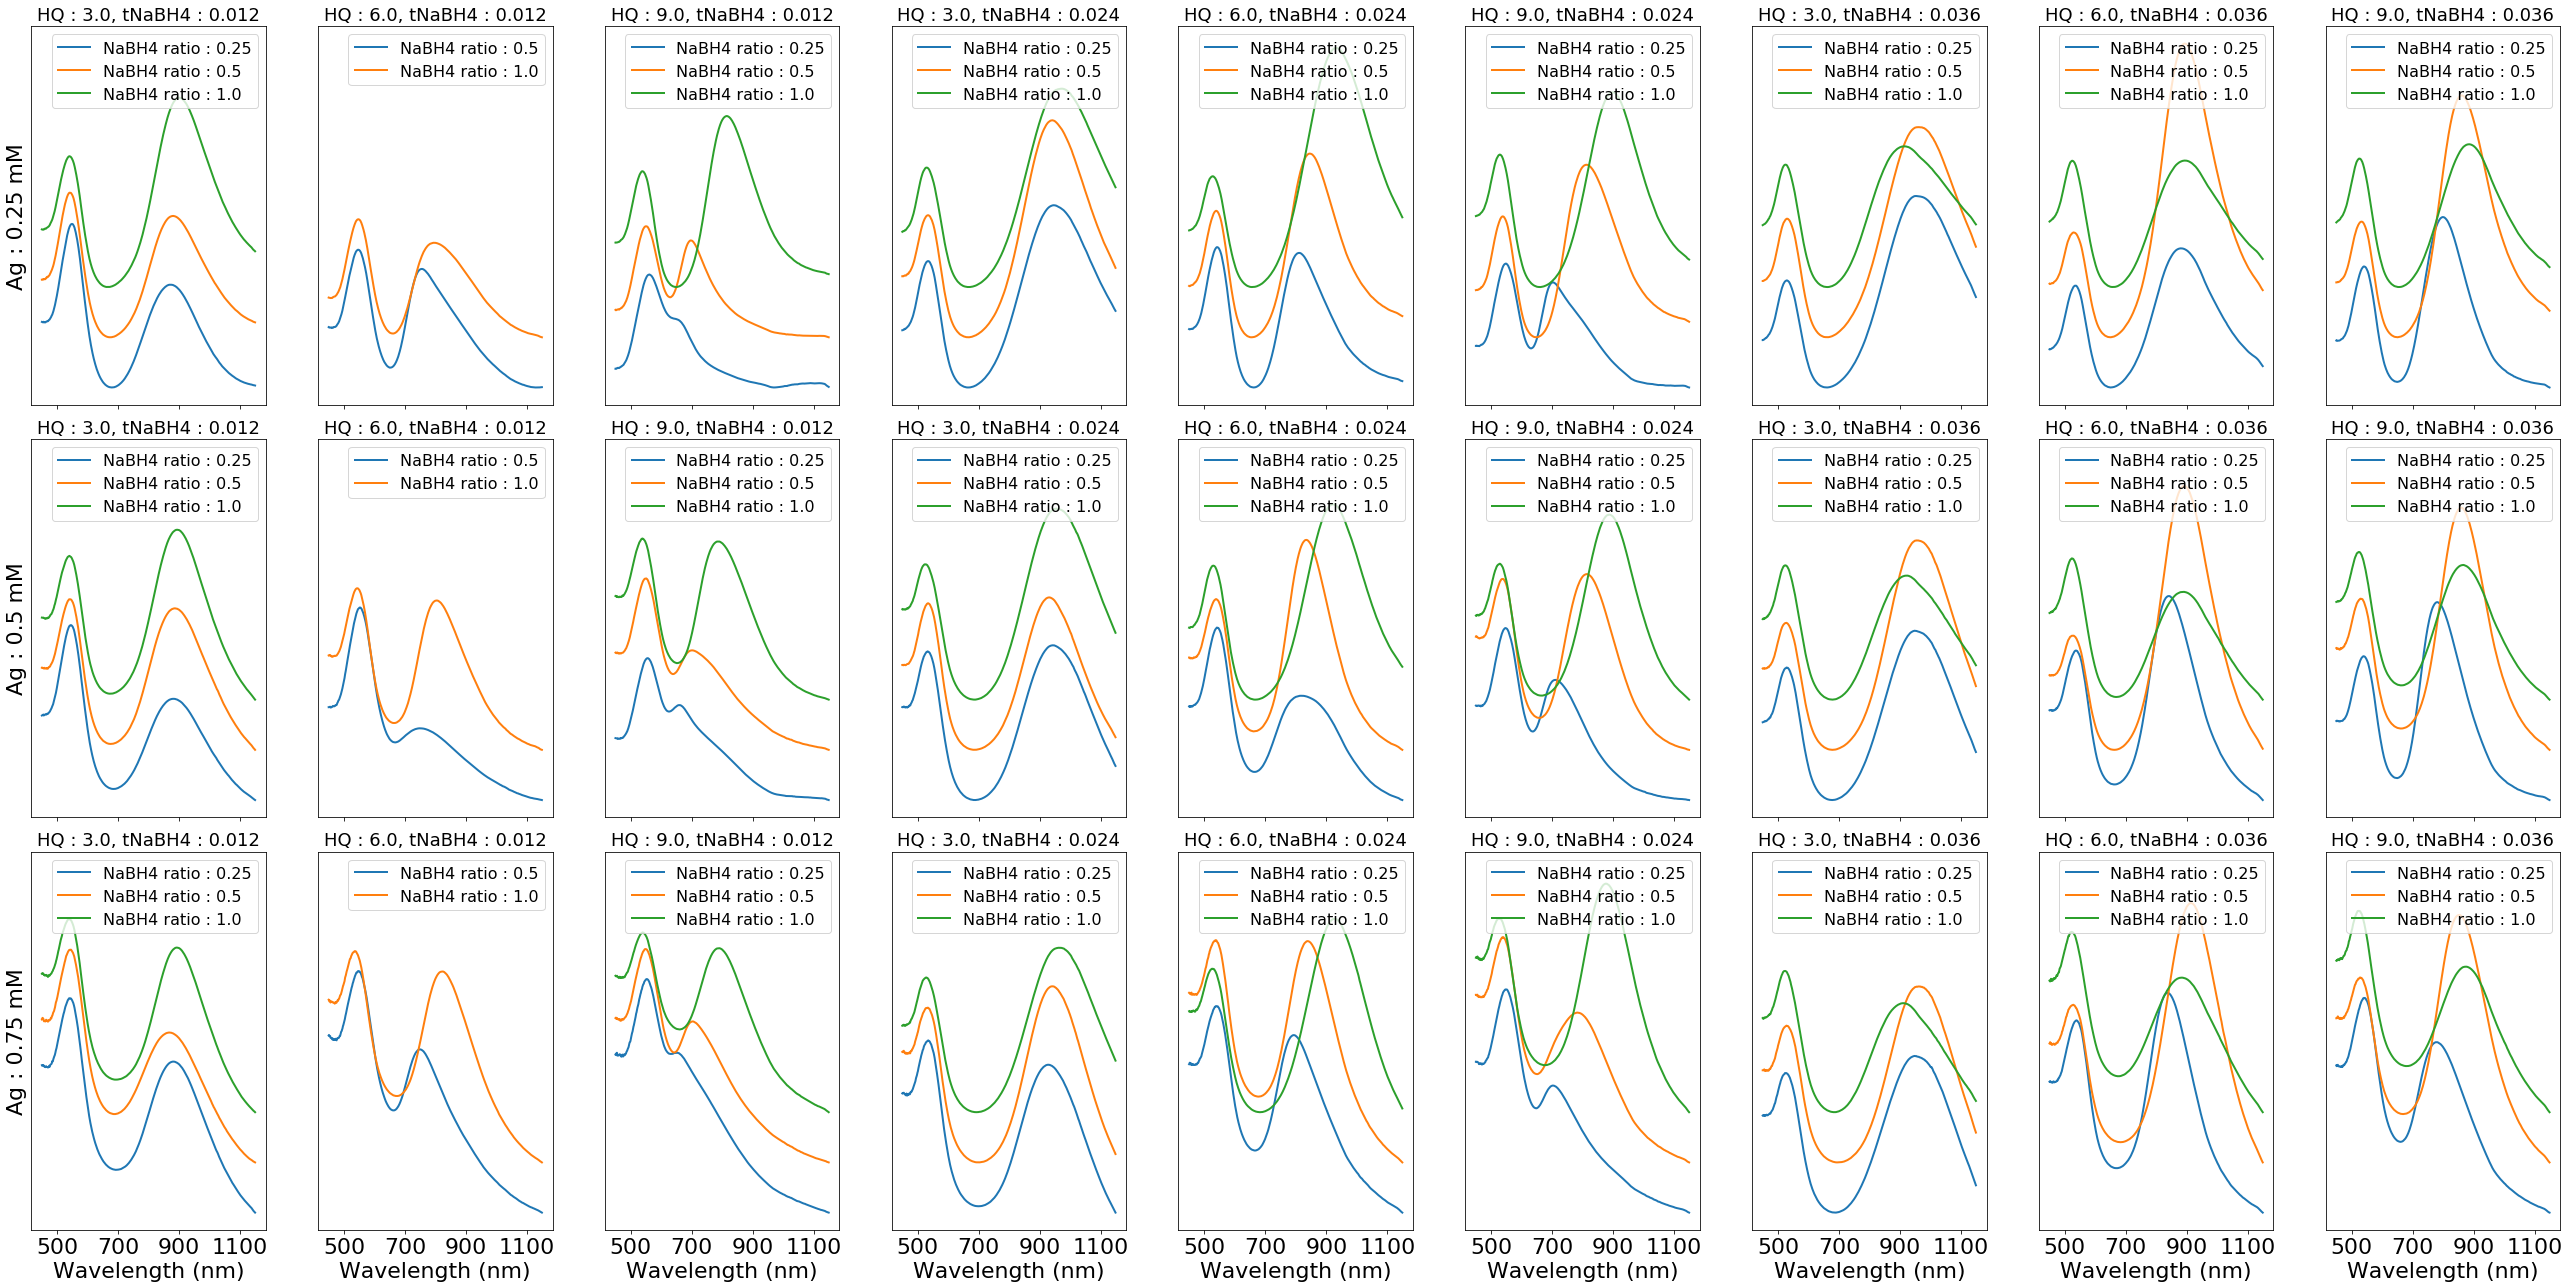

In [77]:
fig,ax = plt.subplots(3,9,figsize = (36,18),sharex = True, sharey = True)
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(450.0,1150.0,1.0)
concs = [50/500.0,5.0/500.0,60.0/500.0,0.3/500.0]
Nar_un = Fact2_N['rNaBH4'].unique()
Nar_un.sort()
HQ_un = Fact2_N['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2_N['tNaBH4'].unique()
NaBH4_un.sort()
CTAB_un = Fact2_N['Ag'].unique()
CTAB_un.sort()
for i in range(3):
    sel = Fact2_N[Fact2_N['Ag']==CTAB_un[i]]
    ax[i][0].set_ylabel('Ag : ' + str(CTAB_un[i]* concs[1]) + ' mM', fontsize = 22)
    ax[i][0].set_yticks([])
    for j in range(3):
        subsel = sel[sel['tNaBH4']==NaBH4_un[j]]
        for k in range(3):
            subsubsel = subsel[subsel['HQ']==HQ_un[k]]
            ni = 0
            ax[i][j*3+k].set_title('HQ : ' + str(HQ_un[k]*concs[2]) + ', tNaBH4 : ' + str(round(NaBH4_un[j]*concs[3], 4)), fontsize = 18)
            if i==2:
                ax[i][j*3+k].set_xlabel('Wavelength (nm)', fontsize = 22)
                ax[i][j*3+k].tick_params(labelsize = 22)
                ax[i][j*3+k].set_xticks([500,700,900,1100])
            subsubsel = subsubsel.sort_values('rNaBH4')
            for ri in subsubsel.index:
                if ri not in ['B8', 'D8', 'F8']:
                    # ax[i][j*3+k].plot(absorption,ni+subsubsel.loc[ri,absorption], linewidth = 2, label =  ri)
                    ax[i][j*3+k].plot(absorption,ni+subsubsel.loc[ri,absorption],label = 'NaBH4 ratio : ' + str(round(subsubsel.loc[ri,'rNaBH4'],2)), linewidth = 2)
                    ni+=0.15
            ax[i][j*3+k].legend(prop = {'size' : 16})
fig.tight_layout()
plt.show()
        

In [51]:
Fact2_N

,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450.0,451.0,452.0,...,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,tNaBH4,rNaBH4
A1,155.0,160.0,50.0,25.0,50.0,60.0,0.0,0.195703,0.196977,0.197211,...,0.091742,0.090426,0.089211,0.088136,0.087071,0.086046,0.084995,0.083977,60.0,1.00
A10,170.0,160.0,50.0,25.0,75.0,20.0,0.0,0.132840,0.132541,0.132887,...,0.040285,0.039961,0.039785,0.039709,0.039518,0.039254,0.038950,0.038615,20.0,1.00
A11,120.0,160.0,50.0,75.0,75.0,5.0,15.0,0.472375,0.474304,0.472070,...,0.002008,0.001680,0.001363,0.001118,0.000947,0.000616,0.000231,0.000000,20.0,0.25
A2,105.0,160.0,50.0,75.0,50.0,15.0,45.0,0.391147,0.391924,0.392902,...,0.006065,0.004997,0.004042,0.003166,0.002299,0.001514,0.000744,0.000000,60.0,0.25
A3,155.0,160.0,50.0,50.0,25.0,15.0,45.0,0.232278,0.232606,0.233524,...,0.159319,0.156719,0.154357,0.152104,0.149961,0.147755,0.145600,0.143396,60.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H5,200.0,160.0,50.0,25.0,25.0,20.0,20.0,0.182366,0.182407,0.182681,...,0.220956,0.218695,0.216605,0.214695,0.212852,0.211041,0.209192,0.207388,40.0,0.50
H6,100.0,160.0,50.0,75.0,75.0,40.0,0.0,0.461653,0.461305,0.462854,...,0.007716,0.006343,0.005263,0.004321,0.003233,0.002269,0.001147,0.000000,40.0,1.00
H7,170.0,160.0,50.0,50.0,50.0,20.0,0.0,0.281945,0.282322,0.283535,...,0.002857,0.002144,0.001655,0.001347,0.001022,0.000708,0.000367,0.000000,20.0,1.00
H8,220.0,160.0,50.0,25.0,25.0,20.0,0.0,0.172326,0.171662,0.171685,...,0.112810,0.111844,0.111095,0.110428,0.109637,0.108818,0.107918,0.106893,20.0,1.00


[ 450.  451.  452.  453.  454.  455.  456.  457.  458.  459.  460.  461.
  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.  472.  473.
  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.  484.  485.
  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.  496.  497.
  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.  508.  509.
  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.  520.  521.
  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.  532.  533.
  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.  544.  545.
  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.  556.  557.
  558.  559.  560.  561.  562.  563.  564.  565.  566.  567.  568.  569.
  570.  571.  572.  573.  574.  575.  576.  577.  578.  579.  580.  581.
  582.  583.  584.  585.  586.  587.  588.  589.  590.  591.  592.  593.
  594.  595.  596.  597.  598.  599.  600.  601.  602.  603.  604.  605.
  606.  607.  608.  609.  610.  611.  612.  613.  6

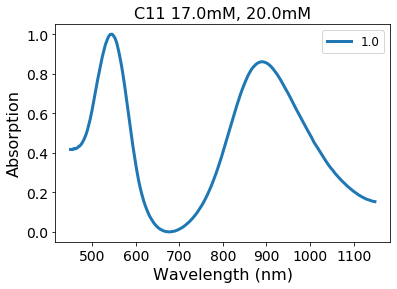


40.0


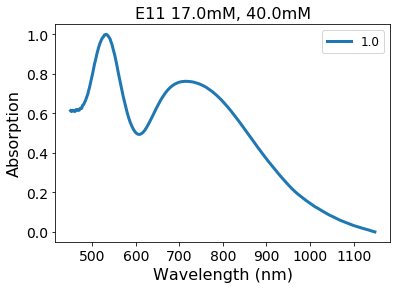


20.0


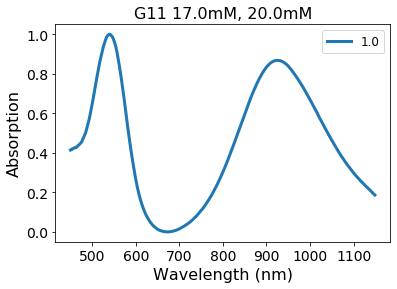


10.0


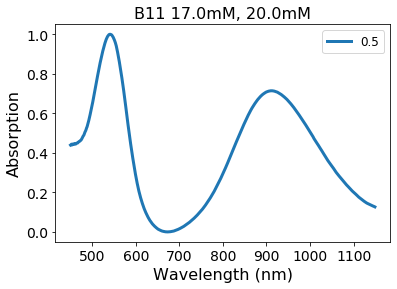


5.0


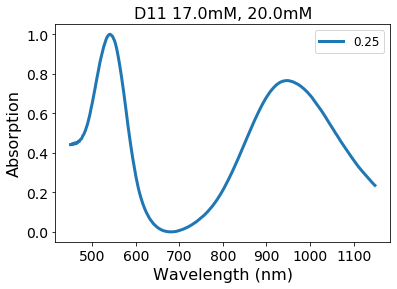


30.0


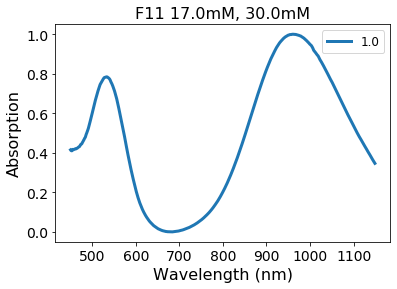


15.0


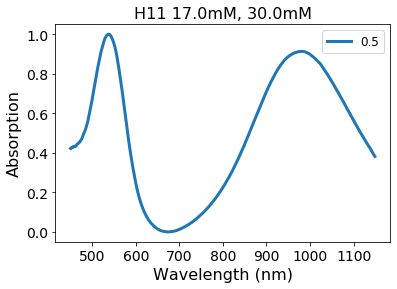


8.0


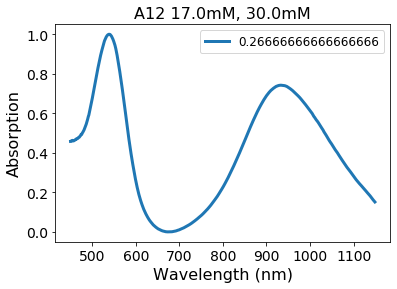


40.0


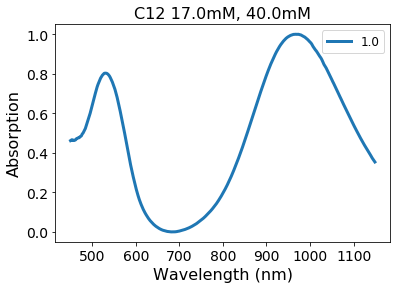


20.0


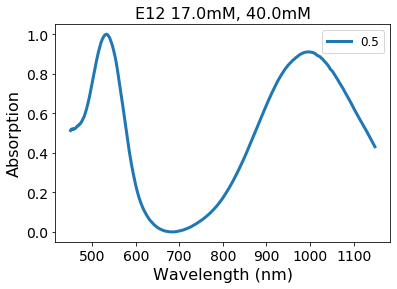


10.0


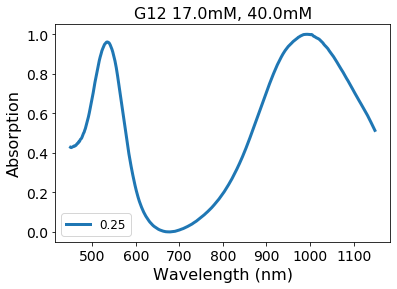


60.0


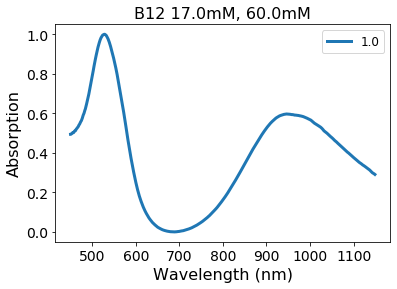


30.0


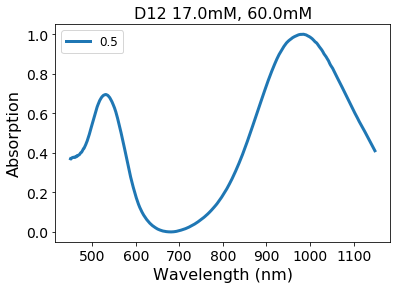


9.0


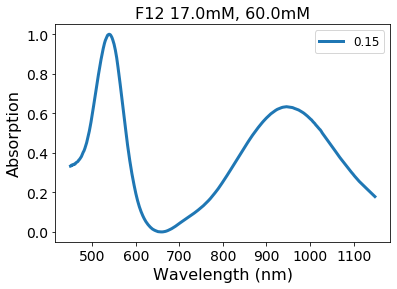

In [81]:
import joblib
names = ['C11','E11','G11','B11','D11','F11','H11','A12','C12','E12','G12','B12','D12','F12']
# names = ['G11', 'B11']
for name in names:
    tNaBH4 = Nirvana2_scmerge.loc[name, 'NaBH4'] + Nirvana2_scmerge.loc[name, 'NaBH4_2nd']
    NaBH4_ratio = Nirvana2_scmerge.loc[name, 'NaBH4']/tNaBH4
    plt.plot(absorption,Nirvana2_scmerge.loc[name, absorption]/max(Nirvana2_scmerge.loc[name, absorption]), linewidth = 3, label = NaBH4_ratio)
    plt.xlabel("Wavelength (nm)", fontsize = 16)
    plt.ylabel("Absorption", fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    print()
    print(Nirvana2_scmerge.loc[name, 'NaBH4'])
    plot_title = name + ' ' + str(Nirvana2_scmerge.loc['F12', 'HQ']) + 'mM, ' + str(tNaBH4) + 'mM'
    plt.title(plot_title, fontsize = 16)
    plt.legend(fontsize = 12)
    joblib.dump([absorption, Nirvana2_scmerge.loc[name,absorption]], name + "_Nimbus_033021.joblib")
    plt.show()


In [76]:
Nirvana2_scmerge.to_csv("Nimbus_033021_full.csv")

In [30]:
Fact2_N

,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450.0,451.0,452.0,...,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,tNaBH4,rNaBH4
A1,155.0,160.0,50.0,25.0,50.0,60.0,0.0,0.195703,0.196977,0.197211,...,0.091742,0.090426,0.089211,0.088136,0.087071,0.086046,0.084995,0.083977,60.0,1.00
A10,170.0,160.0,50.0,25.0,75.0,20.0,0.0,0.132840,0.132541,0.132887,...,0.040285,0.039961,0.039785,0.039709,0.039518,0.039254,0.038950,0.038615,20.0,1.00
A11,120.0,160.0,50.0,75.0,75.0,5.0,15.0,0.472375,0.474304,0.472070,...,0.002008,0.001680,0.001363,0.001118,0.000947,0.000616,0.000231,0.000000,20.0,0.25
A2,105.0,160.0,50.0,75.0,50.0,15.0,45.0,0.391147,0.391924,0.392902,...,0.006065,0.004997,0.004042,0.003166,0.002299,0.001514,0.000744,0.000000,60.0,0.25
A3,155.0,160.0,50.0,50.0,25.0,15.0,45.0,0.232278,0.232606,0.233524,...,0.159319,0.156719,0.154357,0.152104,0.149961,0.147755,0.145600,0.143396,60.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H5,200.0,160.0,50.0,25.0,25.0,20.0,20.0,0.182366,0.182407,0.182681,...,0.220956,0.218695,0.216605,0.214695,0.212852,0.211041,0.209192,0.207388,40.0,0.50
H6,100.0,160.0,50.0,75.0,75.0,40.0,0.0,0.461653,0.461305,0.462854,...,0.007716,0.006343,0.005263,0.004321,0.003233,0.002269,0.001147,0.000000,40.0,1.00
H7,170.0,160.0,50.0,50.0,50.0,20.0,0.0,0.281945,0.282322,0.283535,...,0.002857,0.002144,0.001655,0.001347,0.001022,0.000708,0.000367,0.000000,20.0,1.00
H8,220.0,160.0,50.0,25.0,25.0,20.0,0.0,0.172326,0.171662,0.171685,...,0.112810,0.111844,0.111095,0.110428,0.109637,0.108818,0.107918,0.106893,20.0,1.00


In [31]:
peaks = [find_peaks(sgf(Fact2_N.loc[ni,np.arange(500.0,1150.0,1.0)],61,4),width = 5) for ni in Fact2.index]

In [32]:
derivpeaks = [find_peaks(sgf(Fact2_N.loc[ni,np.arange(500.0,1150.0,1.0)],61,4,deriv = 1),width = 20) for ni in Fact2.index]

In [33]:
print([max(peak[0]) for peak in peaks])

[394, 315, 151, 337, 449, 300, 339, 432, 312, 322, 394, 392, 201, 462, 374, 422, 472, 429, 210, 254, 368, 388, 287, 415, 449, 281, 311, 442, 313, 255, 393, 414, 203, 457, 361, 427, 455, 398, 203, 222, 372, 383, 288, 421, 385, 278, 318, 446, 283, 250, 380, 381, 619, 462, 359, 346, 465, 387, 296, 204, 381, 393, 623, 411, 365, 432, 293, 443, 623, 249, 386, 341, 159, 454, 352, 334, 441, 377, 304, 400, 381]


In [34]:
print([max(peak[0]) for peak in derivpeaks])

[617, 617, 617, 617, 622, 614, 624, 628, 621, 632, 631, 623, 617, 621, 617, 631, 626, 336, 617, 197, 283, 618, 623, 617, 618, 616, 617, 357, 629, 355, 321, 628, 623, 623, 617, 634, 626, 630, 616, 188, 281, 618, 617, 616, 618, 616, 620, 629, 616, 632, 303, 616, 517, 618, 618, 618, 626, 628, 618, 621, 625, 624, 616, 617, 617, 630, 617, 627, 615, 621, 625, 617, 615, 617, 618, 618, 625, 625, 616, 633, 626]


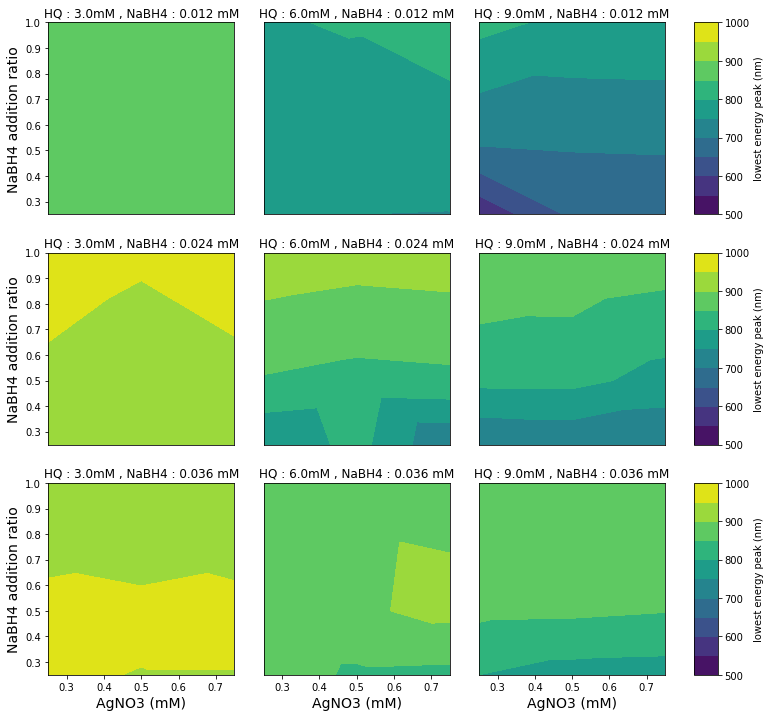

In [35]:
fig,ax = plt.subplots(3,4,figsize = (12,12),gridspec_kw = {'width_ratios' : [8,8,8,1]})
# labels = ['CTAB','Ag','HQ','NaBH4']
absorption = np.arange(400.0,1100.0,1.0)
concs = [5/500.0,0.3/500.0,60.0/500.0]
Ag_un = Fact2_N['Ag'].unique()
Ag_un.sort()
HQ_un = Fact2_N['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2_N['tNaBH4'].unique()
NaBH4_un.sort()
for i in range(3):
    sel = Fact2_N[Fact2_N['tNaBH4']== NaBH4_un[i]]
    for j in range(3):
        subsel = sel[sel['HQ']==HQ_un[j]]
        maxpeak = [max(find_peaks(sgf(subsel.loc[ni,np.arange(500.0,1000.0,1.0)],61,4),width = 5)[0]) + 500 for ni in subsel.index]
        a1 = ax[i][j].tricontourf(subsel['Ag']*concs[0],subsel['rNaBH4'],maxpeak, levels = np.linspace(500,1000,11))
        ax[i][j].set_title('HQ : ' + str(HQ_un[j]*concs[2]) + 'mM , NaBH4 : ' + str(round(NaBH4_un[i]*concs[1],4)) + ' mM')
        if i==2:
            ax[i][j].set_xlabel('AgNO3 (mM)', fontsize = 14)
        else:
            ax[i][j].set_xticks([])
        if j==0:
            ax[i][j].set_ylabel('NaBH4 addition ratio', fontsize = 14)
        else:
            ax[i][j].set_yticks([])
    fig.colorbar(a1,cax = ax[i][3],label = 'lowest energy peak (nm)')

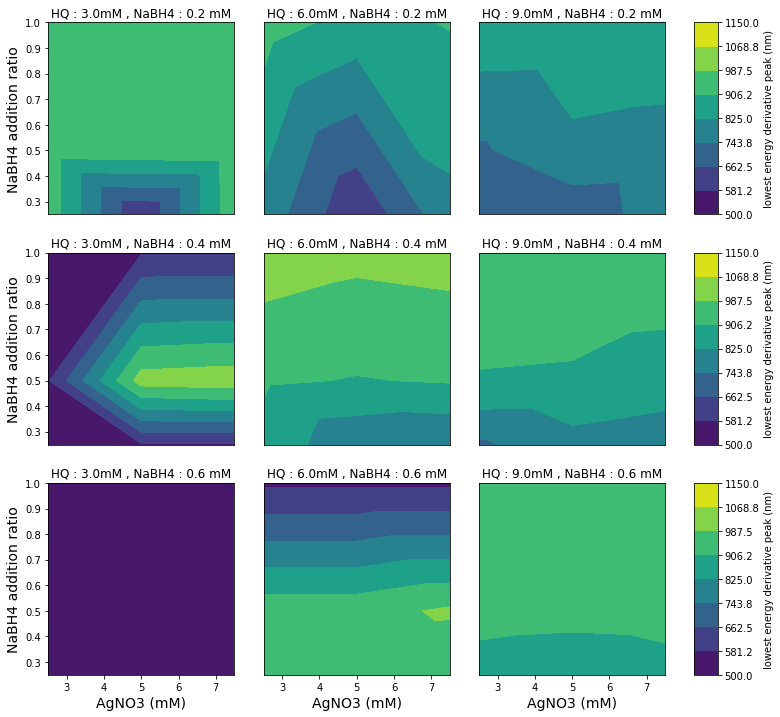

In [157]:
fig,ax = plt.subplots(3,4,figsize = (12,12),gridspec_kw = {'width_ratios' : [8,8,8,1]})
labels = ['CTAB','Ag','HQ','NaBH4']
absorption = np.arange(400.0,1150.0,1.0)
concs = [50.0/500.0,5.0/500.0,60.0/500.0,0.3/500.0]
Ag_un = Fact2_N['Ag'].unique()
Ag_un.sort()
HQ_un = Fact2_N['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2_N['tNaBH4'].unique()
NaBH4_un.sort()
for i in range(3):
    sel = Fact2_N[Fact2_N['tNaBH4']== NaBH4_un[i]]
    for j in range(3):
        subsel = sel[sel['HQ']==HQ_un[j]]
        maxpeak = [max(list(find_peaks(-sgf(subsel.loc[ni,np.arange(500.0,1150.0,1.0)],61,4,deriv = 1),width = 20,prominence = 0.001)[0]) + [0]) + 500 for ni in subsel.index]
        a1 = ax[i][j].tricontourf(subsel['Ag']*concs[0],subsel['rNaBH4'],maxpeak, levels = np.linspace(500,1150,9))
        ax[i][j].set_title('HQ : ' + str(HQ_un[j]*concs[2]) + 'mM , NaBH4 : ' + str(NaBH4_un[i]*concs[1]) + ' mM')
        if i==2:
            ax[i][j].set_xlabel('AgNO3 (mM)', fontsize = 14)
        else:
            ax[i][j].set_xticks([])
        if j==0:
            ax[i][j].set_ylabel('NaBH4 addition ratio', fontsize = 14)
        else:
            ax[i][j].set_yticks([])
    fig.colorbar(a1,cax = ax[i][3],label = 'lowest energy derivative peak (nm)')

In [230]:
absorption = np.arange(350.0,1000.0,1.0)
bg_sub2 = [scat_subtract_noneg(list((merge2.loc[index,absorption]-merge2.loc['H12',absorption]).values),absorption,600,649) for index in merge2.index]

      fun: 0.01078568770700799
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.42170353, 0.1000018 , 0.63983946])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 248
      nit: 32
   status: 0
  success: True
        x: array([-0.98927462,  1.99401142,  0.        ])
      fun: 0.012450545799629535
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.23515343, 0.04288497, 0.67280244])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 392
      nit: 30
   status: 2
  success: False
        x: array([-0.99267084,  1.93734571,  0.        ])
      fun: 0.07143912674850655
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.99752079, 0.33142282, 3.64862174])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 460
      nit: 29
   status: 0
  success: True
        x: array([-1.12329349,  2.05639217,  0.        ])
      fun: 0.1436595257762719
 hess_inv: <3x3 LbfgsInvH

      fun: 0.036181880305950265
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.42419954e-01, 1.72571540e-03, 1.74481046e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 23
   status: 0
  success: True
        x: array([-0.98597766,  1.7249137 ,  0.        ])
      fun: 0.07825692842471495
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.05334694, 0.00851876, 3.7898302 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 212
      nit: 22
   status: 0
  success: True
        x: array([-2.22721227,  5.3362324 ,  0.        ])
      fun: 0.02585630931442238
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.57605621, 0.16247711, 0.93620759])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 344
      nit: 25
   status: 2
  success: False
        x: array([-0.99129526,  2.15511925,  0.        ])
      fun: 0.04019674166973367
 hess_inv: <

        x: array([-1.30991711,  2.86699047,  0.        ])
      fun: 0.018084985550362538
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.49688417, 1.16255231, 4.90530619])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 404
      nit: 36
   status: 0
  success: True
        x: array([-1.07436616,  2.26608264,  0.        ])
      fun: 0.026388724025744586
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03720373, -0.03058238,  0.97373849])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 636
      nit: 32
   status: 2
  success: False
        x: array([-1.72480725,  4.06678688,  0.        ])
      fun: 0.0137751529688831
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.02703819, 0.22846652, 0.47982226])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 424
      nit: 37
   status: 0
  success: True
        x: array([-0.98511952,  1.96656554,  0.00436

      fun: 0.0670251680889333
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0381595, -0.0203126,  4.4898467])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 552
      nit: 45
   status: 0
  success: True
        x: array([-1.74866296,  3.66355847,  0.        ])
      fun: 0.006301059781589095
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.77941095, 0.8541916 , 0.18596515])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 27
   status: 0
  success: True
        x: array([-0.96069564,  2.2768127 ,  0.1586418 ])
      fun: 0.0238560438420384
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0166598 , -0.01133283,  1.07817639])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 788
      nit: 52
   status: 0
  success: True
        x: array([-1.94108483,  4.5488771 ,  0.        ])
      fun: 0.00949224270425072
 hess_i

In [70]:
for i in range(len(bg_sub2)):
    plt.plot(absorption,bg_sub2[i])
    plt.show()

NameError: name 'bg_sub2' is not defined

In [233]:
bg_sub2dat = pd.DataFrame(bg_sub2,columns = absorption, index = merge2.index)
merge_bgsub2 = pd.merge(amts,bg_sub2dat,left_index = True, right_index = True)
merge_bgsub2.to_csv('bg_subtracted_nd2.csv')

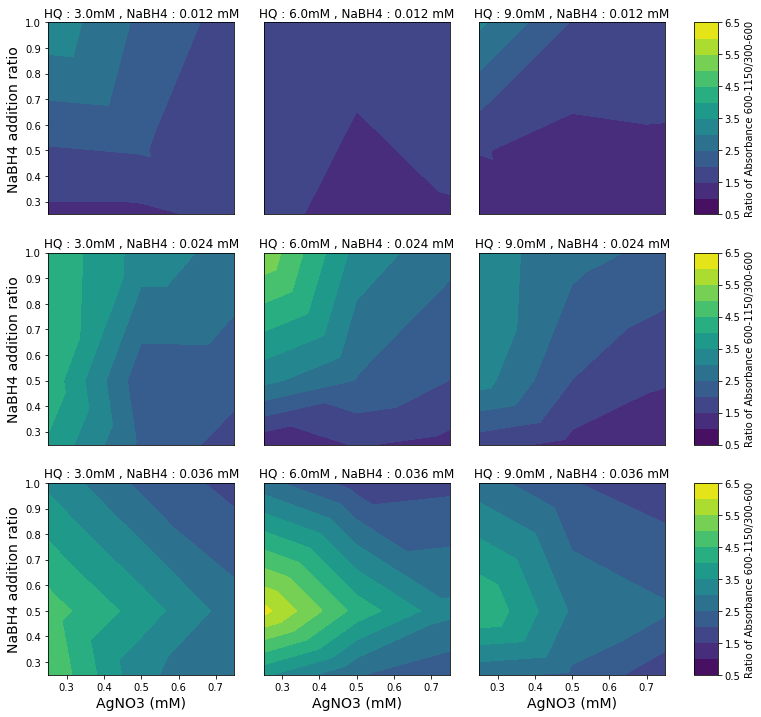

In [163]:
fig,ax = plt.subplots(3,4,figsize = (12,12),gridspec_kw = {'width_ratios' : [8,8,8,1]})
labels = ['CTAB','Ag','HQ','NaBH4']
absorption = np.arange(400.0,1150.0,1.0)
concs = [5/500.0,0.3/500.0,60.0/500]
Ag_un = Fact2_N['Ag'].unique()
Ag_un.sort()
HQ_un = Fact2_N['HQ'].unique()
HQ_un.sort()
NaBH4_un = Fact2_N['tNaBH4'].unique()
NaBH4_un.sort()
for i in range(3):
    sel = Fact2_N[Fact2_N['tNaBH4']== NaBH4_un[i]]
    for j in range(3):
        subsel = sel[sel['HQ']==HQ_un[j]]
        subsel_x1 = subsel[np.arange(450.0,600.0)].sum(axis = 1)
        subsel_x2 = subsel[np.arange(600.0,1150.0)].sum(axis = 1)
        a1 = ax[i][j].tricontourf(subsel['Ag']*concs[0],subsel['rNaBH4'],subsel_x2/subsel_x1, levels = np.linspace(0.5, 6.5, 13))
        ax[i][j].set_title('HQ : ' + str(HQ_un[j]*concs[2]) + 'mM , NaBH4 : ' + str(round(NaBH4_un[i]*concs[1],4)) + ' mM')
        if i==2:
            ax[i][j].set_xlabel('AgNO3 (mM)', fontsize = 14)
        else:
            ax[i][j].set_xticks([])
        if j==0:
            ax[i][j].set_ylabel('NaBH4 addition ratio', fontsize = 14)
        else:
            ax[i][j].set_yticks([])
    fig.colorbar(a1,cax = ax[i][3],label = 'Ratio of Absorbance 600-1150/300-600')